### Rappel et téléchargments nécessaires pour Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator.

Ensuite, pour chacune des deux parties du laboratoire, on a besoin de jeux de données spécifiques. Sur **Google Colab**, exécutez les deux prochaines cellules de code pour les télécharger et les extraire. Sur Helios, les jeux de données y sont déjà présent. Il ne faut donc pas exécuter les deux prochaines cellules de code. 

 Pour télécharger et extraire le petit jeu de données de traduction de la première partie sur **Google Colab**:

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!mkdir -p ~/GLO-4030/datasets/translation
!unzip data.zip -d ~/GLO-4030/datasets/translation

Pour télécharger et extraire les plongements de mots (*word embeddings*) pré-entraînés de la deuxième partie sur **Google Colab**:

In [ ]:
!wget https://graal.ift.ulaval.ca/public/embeddings-glo-4030-7030.zip
!mkdir -p ~/GLO-4030/embeddings/
!unzip embeddings-glo-4030-7030.zip -d ~/GLO-4030/embeddings/

# Laboratoire 7 - seq2seq, embedding

## Instructions - À lire

Ce laboratoire est sous forme de tutoriel et comporte peu d'exercices. Il y a tout de même quelques **TODO dans le code à compléter**. Le tutoriel original de ce laboratoire est disponible à l'adresse suivante: http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

L'entraînement du réseau avec attention peut prendre un certain temps. Il est donc conseillé de sauter à la dernière section sur les embeddings avant de commencer l'entraînement.

Ce laboratoire est écrit en anglais. 

## Partie 1: Translation with a sequence to sequence network and attention

In this lab, project we will be teaching a neural network to translate from French to English.
    
    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](https://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

![seq2seq](http://pytorch.org/tutorials/_images/seq2seq.png)

To improve upon this model we'll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [4]:
def readLangs(path, lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    path = os.path.expanduser(path)
    lines = open(os.path.join(path, '%s-%s.txt' % (lang1, lang2)), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [6]:
def prepareData(path, lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(path, lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('~/GLO-4030/datasets/translation/data/', 'eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis tres fatigue .', 'i m very tired .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [`Sequence to Sequence network`](https://arxiv.org/abs/1409.3215), or
seq2seq network, or [`Encoder Decoder
network`](https://arxiv.org/pdf/1406.1078v3.pdf), is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

![seq2seq](http://pytorch.org/tutorials/_images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![encoder](http://pytorch.org/tutorials/_images/encoder-network.png)





In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        # TODO: See previous graph as reference to code this forward function.
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
        # TODO END

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

![simple decoder](http://pytorch.org/tutorials/_images/decoder-network.png)

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        # TODO: See previous graph as reference to code this forward function.
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
        # TODO END

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




### Attention Decoder


If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

![attention_decoder](https://i.imgur.com/1152PYf.png)

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![attention_decoder2](http://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in Effective Approaches to Attention-based Neural Machine
  Translation (https://arxiv.org/abs/1508.04025).</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. **Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state**.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](<http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [11]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # TODO initialize the input of the decoder
    # decoder_input = ...
    decoder_input = torch.tensor([[SOS_token]])
    # TODO END
    decoder_input = decoder_input.to(device)

    # TODO Assign the hidden state
    # decoder_hidden = ...
    decoder_hidden = encoder_hidden
    # TODO END

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [13]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [14]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # TODO initialize the input of the decoder
        # decoder_input = ...
        decoder_input = torch.tensor([[SOS_token]])
        # TODO END
        decoder_input = decoder_input.to(device)

        # TODO Assign the hidden state
        # decoder_hidden = ...
        decoder_hidden = encoder_hidden
        # TODO END

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

Note: If you run this notebook you can train, interrupt the kernel,
evaluate, and continue training later. Comment out the lines where the
encoder and decoder are initialized and run ``trainIters`` again.




2m 43s (- 38m 3s) (5000 6%) 2.8450
5m 25s (- 35m 14s) (10000 13%) 2.2711
8m 6s (- 32m 26s) (15000 20%) 1.9565
10m 48s (- 29m 42s) (20000 26%) 1.7135
13m 32s (- 27m 4s) (25000 33%) 1.5168
16m 15s (- 24m 22s) (30000 40%) 1.3704
18m 59s (- 21m 41s) (35000 46%) 1.1981
21m 42s (- 18m 59s) (40000 53%) 1.0943
24m 25s (- 16m 17s) (45000 60%) 0.9662
27m 8s (- 13m 34s) (50000 66%) 0.8845
29m 52s (- 10m 51s) (55000 73%) 0.7849
32m 36s (- 8m 9s) (60000 80%) 0.6890
35m 20s (- 5m 26s) (65000 86%) 0.6466
38m 4s (- 2m 43s) (70000 93%) 0.6238
40m 48s (- 0m 0s) (75000 100%) 0.5376


<Figure size 432x288 with 0 Axes>

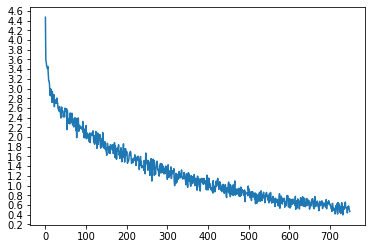

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [18]:
evaluateRandomly(encoder1, attn_decoder1)

> tu fais un boulot excellent .
= you re doing an excellent job .
< you re doing my job . <EOS>

> je vais le tuer pour ca !
= i m going to kill him for this !
< i m going to call this this this . <EOS>

> vous n etes pas different .
= you re no different .
< you re no different . <EOS>

> t es libre d y aller .
= you re free to go .
< you re free to go . <EOS>

> vous etes degoutantes .
= you re disgusting .
< you re disgusting . <EOS>

> tu es tres intelligent .
= you re very intelligent .
< you re very intelligent . <EOS>

> il est methodique .
= he is a methodical person .
< he s an author . <EOS>

> je viens d angleterre .
= i m from england .
< i m from england . <EOS>

> nous ne sommes pas de la meme famille .
= we re not family .
< we re not family . <EOS>

> je ne suis pas parfait .
= i m not perfect .
< i m not perfect . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




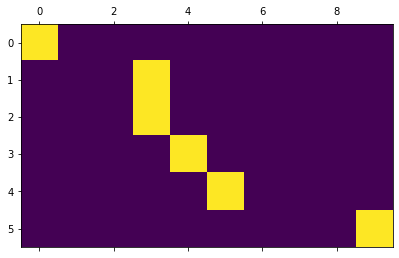

In [19]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


<ipython-input-20-9b51ff8fc28e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-20-9b51ff8fc28e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


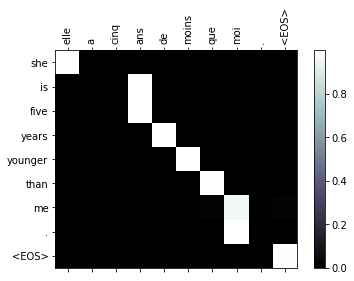

input = elle est trop petit .
output = she s too short . <EOS>


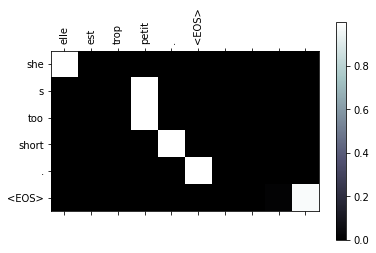

input = je ne crains pas de mourir .
output = i m not dying he die . <EOS>


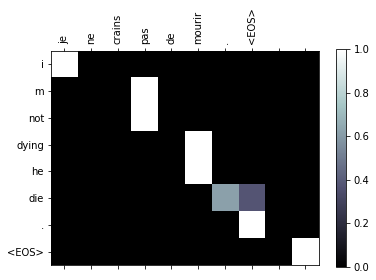

input = c est un jeune directeur plein de talent .
output = he s a talented young talented . <EOS>


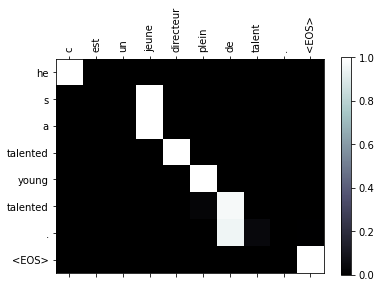

In [20]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

## Partie 2: Plongement de mots (*embeddings*)

Dans l'exemple de la traduction que l'on vient de faire, les plongements de mots ont été entraînés à partir de zéro. Ici, l'on va utiliser des plongements de mots pré-entrainés sur des grands jeux de données tel que le corpus de Wikipédia.

Les plongements de mots anglais viennent de https://nlp.stanford.edu/projects/glove/.

Les plongements de mots français viennent de  http://fauconnier.github.io/.

> Si vous êtes sur Google Colab, n'oubliez pas de les télécharger avec les trois lignes de commande au début du notebook si ce n'est déjà fait.

In [21]:
import os
import gensim
from scipy import spatial

base_path = os.path.expanduser('~/GLO-4030/embeddings/')

In [22]:
fr_model = gensim.models.KeyedVectors.load_word2vec_format(os.path.join(base_path, 'frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin'), binary=True)
en_model = gensim.models.KeyedVectors.load_word2vec_format(os.path.join(base_path, 'glove.6B.200d.w2v'))

Affichons le vecteur du mot "fromage" dans le modèle de langue française.

In [23]:
fr_model['fromage']

array([-0.2664362 , -0.4299445 ,  0.6510633 ,  1.0772692 ,  1.5520236 ,
        0.2495723 ,  0.26629683, -0.89362895, -0.49371314,  0.18303041,
        0.34588683, -0.11292784,  0.97348493,  1.2326939 ,  0.35498488,
       -0.4481784 , -0.68868834, -1.591207  ,  0.9300429 , -0.33489245,
       -0.2787414 , -1.3970721 , -0.57521236, -1.002458  ,  0.8013476 ,
       -1.3411416 ,  0.76935387, -1.1733383 ,  0.22591951, -0.21946736,
       -0.86721236, -0.3146531 , -0.18852806,  1.0271074 ,  0.3422212 ,
       -0.7188593 ,  0.48196372,  0.22215955, -1.1832696 , -1.3042392 ,
       -0.1793483 , -0.03065129,  0.5137579 , -0.46386078, -0.44896987,
       -0.821054  , -1.4909775 , -1.6710725 ,  0.9365932 , -0.4619354 ,
       -0.0040745 , -0.28049183,  0.15620519, -0.96698225, -1.0262544 ,
       -1.4730241 , -0.12871675,  0.03265834, -1.5044014 ,  0.3174789 ,
       -0.07645499,  0.85720867, -1.2462058 , -0.88749665,  0.36963654,
        0.30588707, -0.3780562 , -0.11171415, -0.1615467 ,  0.59

Étant donné que les plongements de mots ne sont que des grands vecteurs, c'est possible d'utiliser une métrique comme la similarité cosinus pour trouver les voisins les plus proches d'un mot. Regardons les voisins de "fromage".

In [24]:
fr_model.most_similar('fromage')

[('fromages', 0.675493597984314),
 ('emmental', 0.6545577049255371),
 ('chèvre', 0.633633553981781),
 ('gruyère', 0.6218554973602295),
 ('faisselle', 0.6053547859191895),
 ('jambon', 0.6005696058273315),
 ('camembert', 0.5846831798553467),
 ('coquillettes', 0.5726486444473267),
 ('poulet', 0.567514955997467),
 ('grillé', 0.5633773803710938)]

Encore mieux on peut faire de l'arithmétique vectorielle pour additionner et soustraire différents concepts. Qu'arrive-t-il si on additionne "king" (roi) avec "woman" (femme) et que l'on soustrait la partie "man" (homme) ?

In [25]:
en_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]

Testons avec d'autres concepts.

In [26]:
en_model.most_similar(positive=['bread', 'cheese', 'ham'])

[('sandwich', 0.7018977999687195),
 ('baked', 0.7011187672615051),
 ('sausage', 0.6871486306190491),
 ('sandwiches', 0.6687703728675842),
 ('slices', 0.6595860719680786),
 ('butter', 0.6592786312103271),
 ('cooked', 0.6543400287628174),
 ('meat', 0.6414679884910583),
 ('chicken', 0.632174551486969),
 ('pasta', 0.624944806098938)]

In [27]:
en_model.most_similar(positive=['lettuce', 'tomato', 'cheese', 'dressing'])

[('salad', 0.7717825770378113),
 ('spinach', 0.7355213165283203),
 ('sauce', 0.715339183807373),
 ('onion', 0.6950131058692932),
 ('mayonnaise', 0.692265510559082),
 ('garlic', 0.6890518665313721),
 ('tomatoes', 0.6851513385772705),
 ('pasta', 0.6827971935272217),
 ('yogurt', 0.6827086806297302),
 ('potatoes', 0.682645857334137)]

In [28]:
en_model.most_similar(positive=['danger', 'fun'], negative=['hurt'])

[('dangers', 0.49281057715415955),
 ('adventure', 0.49240127205848694),
 ('peril', 0.48172539472579956),
 ('entertaining', 0.4816499948501587),
 ('sort', 0.46983006596565247),
 ('thrill', 0.45954400300979614),
 ('imagine', 0.4591182768344879),
 ('frightening', 0.4581250548362732),
 ('irony', 0.45598921179771423),
 ('humor', 0.4534699618816376)]

In [29]:
fr_model.most_similar(positive=['canada', 'plaisir'])

[('québec', 0.6022888422012329),
 ('montréal', 0.5355085730552673),
 ('québécois', 0.5239726901054382),
 ('ontario', 0.523745596408844),
 ('gaspésie', 0.4820100963115692),
 ('montreal', 0.47807785868644714),
 ('québécoise', 0.475710928440094),
 ('canadienne', 0.4713665843009949),
 ('canadiens', 0.470713347196579),
 ('sherbrooke', 0.4617931544780731)]

In [30]:
fr_model.most_similar(positive=['canada'], negative=['plaisir'])

[('ottawa', 0.5476916432380676),
 ('canadienne', 0.5457198023796082),
 ('québec', 0.537995457649231),
 ('ontario', 0.5369740724563599),
 ('canadiennes', 0.5116544365882874),
 ('montréal', 0.5041353702545166),
 ('canadien', 0.5031552314758301),
 ('alberta', 0.502679705619812),
 ('grande-bretagne', 0.47960031032562256),
 ('colombie-britannique', 0.4748367667198181)]

#### Exercice

* Amusez-vous à faire des opérations arithmétiques avec les plongements de mots.

In [ ]:
# TODO